# Is it a Picasso?

This notebook implements a machine learning model to differentiate between Picasso and other artists using paintings.

## Step 1: Download the training data

We are using fastai library helpers and DuckDuckGo search engine to download paintings from Picasso and Rembrandt to train our model. Once the images are downloaded, we use `verify_images(...)` method from fastai lib to remove image urls that can't be successfully downloaded.

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import Path, L
from fastai.vision.all import Image, download_images, resize_images, verify_images, get_image_files

def search_images(query, max_images=30):
    print(f"Searching for {query} images...")
    return L(ddg_images(query, max_results=max_images)).itemgot("image")

data_classes = 'picasso', 'rembrandt'
path = Path('picasso_or_not')

for data_class in data_classes:
    destination = path/data_class
    destination.mkdir(exist_ok=True, parents=True)
    download_images(destination, urls=search_images(f"{data_class} famous paintings"))
    resize_images(destination, max_size=400, dest=destination)

failed_images = verify_images(get_image_files(path))
failed_images.map(Path.unlink)
print(f"Removed {len(failed_images)} images that couldn't be processed by verify_images(...)")

Searching for picasso famous paintings images...
Searching for rembrandt famous paintings images...
Removed 4 images that couldn't be processed by verify_images(...)


## Step 2: Build dataloaders and train our model

The fastai library uses the concept of `DataLoaders` to load the images, split them into training and validation sets, and apply transformation on the training data to feed into our training model. Once we have the dataloaders built, we can feed them into the model and train/fine-tune it.


Found 270 items
2 datasets of sizes 216,54
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Resize -- {'size': (192, 192), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}


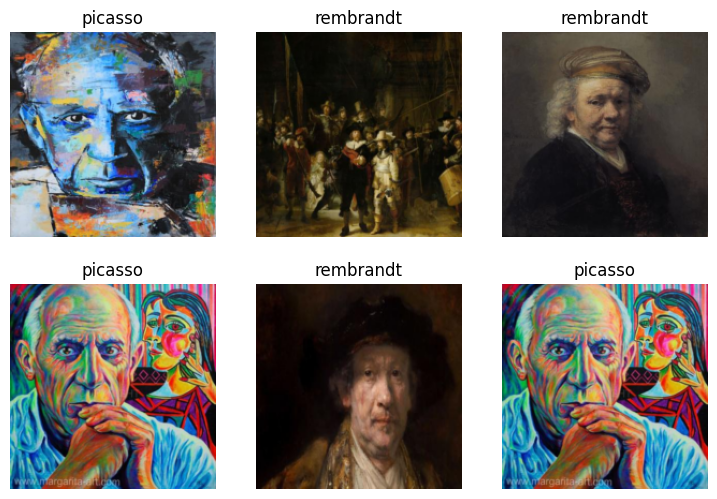

In [3]:
from fastai.data.all import DataBlock, CategoryBlock, RandomSplitter, parent_label
from fastai.vision.all import ImageBlock, Resize, get_image_files

# Generic container to build datasets and dataloaders.
data_loaders = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Model input: images (ImageBlock); model output: categories (CategoryBlock).
    get_items=get_image_files, # See https://docs.fast.ai/data.transforms.html#get_image_files for more info.
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Splits items between train/val using valid_pct.
    get_y=parent_label, # Label each item using the parent folder name (i.e. [picasso, rembrandt]).
    item_tfms=[Resize(192, method='squish')] # Apply a resize transformation using squish method on each image.
).dataloaders(path, bs=32, verbose=True) # Generate dataloades from a source (path) and set batch size (bs) to 32.

data_loaders.show_batch(max_n=6)

Now, we'll fine-tune `resnet18`; a GPT-3 summary:

> ResNet18 is a convolutional neural network (CNN) architecture that was developed by Kaiming He et al. in 2015. It is a deep learning model that is used for image classification and object detection tasks. The model consists of 18 layers, including convolutional layers, pooling layers, and fully connected layers. The model is trained on the ImageNet dataset and has achieved state-of-the-art performance on various image classification tasks. ResNet18 is a lightweight model that is computationally efficient and can be used for real-time applications.

According to fastai's definition of fine-tuning:

> "Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

In [4]:
from fastai.metrics import error_rate
from fastai.vision.all import vision_learner, resnet18

model = vision_learner(data_loaders, resnet18, metrics=error_rate)
model.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.037966,0.000211,0.000000,00:09
1,0.055472,0.000649,0.000000,00:09
2,0.035936,0.001001,0.000000,00:09


## Step 3: Benchmark the model accuracy

It's time to test out the model with unseen Picasso and Rembrandt images and see how it classifies them...

I'm 99.7282% sure this is a picasso


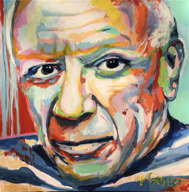

In [5]:
from fastdownload import download_url
from fastai.vision.all import Image

# Picasso example.
destination = 'picasso_test.jpg'
image_url = search_images("picasso famous painting", max_images=1)[0]
download_url(image_url, destination, show_progress=True)
image = Image.open(destination).to_thumb(192, 192)

prediction, _, probabilities = model.predict(image)
print(f"I'm {(probabilities[0] * 100):.4f}% sure this is a {prediction}")
image

I'm 100.0000% sure this is a rembrandt


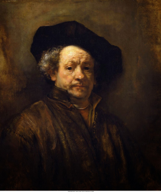

In [6]:
from fastdownload import download_url
from fastai.vision.all import Image

# Rembrandt example.
destination = 'rembrandt_test.jpg'
image_url = search_images("rembrandt famous painting", max_images=1)[0]
download_url(image_url, destination, show_progress=True)
image = Image.open(destination).to_thumb(192, 192)

prediction, _, probabilities = model.predict(image)
print(f"I'm {(probabilities[1] * 100):.4f}% sure this is a {prediction}")
image